<a href="https://colab.research.google.com/github/Manjuphoenix/ML_team_buzz/blob/michelle/v1_Lightning_capptom_improving_accuracy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
from collections import Counter

from PIL import Image

import torch
import torchvision
from torch import utils
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, transforms
import torchvision.models as models
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, random_split, WeightedRandomSampler, ConcatDataset



from sklearn.model_selection import train_test_split
from tqdm import tqdm

import pytorch_lightning as pl


torch.cuda.empty_cache()

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

!pip install kaggle

from google.colab import files 
files.upload()

#Make a directory named kaggle and copy the kaggle.json file there; and change its permissions
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

#imagenet_data = torchvision.datasets.ImageNet('https://kaggle.com/saroz014/plant-diseases')
#data_loader = torch.utils.data.DataLoader(imagenet_data, batch_size=4, shuffle=True, num_workers=args.nThreads)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets download -d manjuphoenix/tomatodataset
!kaggle datasets download -d manjuphoenix/appledataset
!kaggle datasets download -d manjuphoenix/cherrydataset

 98% 901M/923M [00:04<00:00, 260MB/s]
100% 923M/923M [00:04<00:00, 237MB/s]
 97% 323M/333M [00:01<00:00, 181MB/s]
100% 333M/333M [00:01<00:00, 217MB/s]
 73% 72.0M/98.0M [00:00<00:00, 278MB/s]
100% 98.0M/98.0M [00:00<00:00, 266MB/s]


In [ ]:
from zipfile import ZipFile
file_name = 'tomatodataset.zip' #the file is your dataset exact name
with ZipFile(file_name, 'r') as zip:
  #zip.printdir()
  print(zip.extractall())
  #zip.close()
  print('Done')

None
Done


In [ ]:
from zipfile import ZipFile
file_name = 'appledataset.zip' #the file is your dataset exact name
with ZipFile(file_name, 'r') as zip:
  #zip.printdir()
  print(zip.extractall())
  #zip.close()
  print('Done')

None
Done


In [ ]:
from zipfile import ZipFile
file_name = 'cherrydataset.zip' #the file is your dataset exact name
with ZipFile(file_name, 'r') as zip:
  #zip.printdir()
  print(zip.extractall())
  #zip.close()
  print('Done')

None
Done


In [ ]:
!mkdir /content/dataset
!sudo cp -rf /content/Apple/* /content/dataset
!sudo cp -rf /content/Tomato/* /content/dataset
!sudo cp -rf /content/cherry/* /content/dataset

In [ ]:
!pip install torchmetrics

In [ ]:
import torch
from torchvision.transforms import transforms
from PIL import Image
from pathlib import Path
import torchmetrics


# # To get the weights from the .pth file!
class NeuralNetwork(pl.LightningModule):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.cnn = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.relu = nn.LeakyReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=2)
        self.relu2 = nn.LeakyReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(32*65*65, 1000)
        self.fc2 = nn.Linear(1000, 12)
        self.loss = nn.CrossEntropyLoss()

    def forward(self, x):
        out = self.cnn(x)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.cnn2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

    def configure_optimizers(self):
      return torch.optim.SGD(self.parameters(), lr=0.0003, weight_decay=1e-5, momentum=0.6)

    def train_dataloader(self):
      transform = transforms.Compose([transforms.ToTensor(),
        transforms.RandomGrayscale(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(30),
      ])
      data = datasets.ImageFolder('/content/dataset', transform=transform)
      # Split into train/test sets:
      train_len = int(len(data)*0.7)
      train_set, test_set = random_split(data, [train_len, len(data) - train_len])
      # Extract classes:
      train_classes = [train_set.dataset.targets[i] for i in train_set.indices]
      # Calculate support:
      class_count = Counter(train_classes)
      # Calculate class weights:
      class_weights = torch.DoubleTensor([len(train_classes)/c for c in pd.Series(class_count).sort_index().values]) 
      # Sampler needs the respective class weight supplied for each image in the dataset:
      sample_weights = [class_weights[train_set.dataset.targets[i]] for i in train_set.indices]

      sampler = WeightedRandomSampler(weights=sample_weights, num_samples=int(len(train_set)*2), replacement=True)

      batch_size=32
      # Create torch dataloaders:
      train_loader = DataLoader(train_set, batch_size=batch_size, sampler=sampler, num_workers=min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8]))
      return train_loader

    def training_step(self, batch, batch_idx):
      input, label = batch
      output = self(input)
      loss_fn = nn.CrossEntropyLoss()
      loss=loss_fn(output,label)
      # acc = torchmetrics.Accuracy(output, label)
      # pbar = {
      #     'train_accuracy': acc
      # }
      return {'loss': loss}

In [ ]:
model = NeuralNetwork()
checkpoint = torch.load(Path('/content/gdrive/MyDrive/v2_apptom.pk1'))
model.load_state_dict(checkpoint)
print(model)

NeuralNetwork(
  (cnn): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu): LeakyReLU(negative_slope=0.01)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (relu2): LeakyReLU(negative_slope=0.01)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=135200, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=12, bias=True)
  (loss): CrossEntropyLoss()
)


In [ ]:
model.fc2 = nn.Linear(1000,14)
print(model)

NeuralNetwork(
  (cnn): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu): LeakyReLU(negative_slope=0.01)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (relu2): LeakyReLU(negative_slope=0.01)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=135200, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=14, bias=True)
  (loss): CrossEntropyLoss()
)


In [ ]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

es = EarlyStopping(monitor="loss")
trainer = pl.Trainer(max_epochs=25, gpus=1)
trainer.fit(model)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type             | Params
----------------------------------------------
0 | cnn      | Conv2d           | 1.2 K 
1 | relu     | LeakyReLU        | 0     
2 | maxpool  | MaxPool2d        | 0     
3 | cnn2     | Conv2d           | 4.6 K 
4 | relu2    | LeakyReLU        | 0     
5 | maxpool2 | MaxPool2d        | 0     
6 | fc1      | Linear           | 135 M 
7 | fc2      | Linear           | 14.0 K
8 | loss     | CrossEntropyLoss | 0     
----------------------------------------------
135 M     Trainable params
0         Non-

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=25` reached.


In [44]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomGrayscale(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
])


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# Uncomment the below line based on where you train the model----------------------------------------
# !mkdir /kaggle/working/Tomato

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# !cp -r /kaggle/input/plant-diseases/dataset_itr2/dataset_itr2/test/Tomato* /kaggle/working/Tomato
# !cp -r /kaggle/input/plant-diseases/dataset_itr2/dataset_itr2/train/Tomato* /kaggle/working/Tomato

# !rm -rf /kaggle/working/Tomato/Tomato___Leaf_Mold
# !rm -rf /kaggle/working/Tomato/Tomato___Tomato_mosaic_virus 

# Uncomment this for training on kaggle
# data = datasets.ImageFolder('/kaggle/working/Tomato', transform=transform)----------------------------


# This is for training on Local Machine
data = datasets.ImageFolder('/content/dataset', transform=transform)


# Split into train/test sets:
train_len = int(len(data)*0.7)
train_set, test_set = random_split(data, [train_len, len(data) - train_len])

# Extract classes:
train_classes = [train_set.dataset.targets[i] for i in train_set.indices]
# Calculate support:
class_count = Counter(train_classes)
# Calculate class weights:
class_weights = torch.DoubleTensor([len(train_classes)/c for c in pd.Series(class_count).sort_index().values]) 
# Sampler needs the respective class weight supplied for each image in the dataset:
sample_weights = [class_weights[train_set.dataset.targets[i]] for i in train_set.indices]

sampler = WeightedRandomSampler(weights=sample_weights, num_samples=int(len(train_set)*2), replacement=True)

batch_size=32

# Create torch dataloaders:

dataloaders = DataLoader(data, batch_size=batch_size, sampler=sampler, num_workers=min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8]))
print("The total number of images is:", len(dataloaders))

train_loader = DataLoader(train_set, batch_size=batch_size, sampler=sampler, num_workers=min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8]))
print("The number of images in a training set is:", len(train_loader)*batch_size)

val_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8]))
print("The number of images in a test set is:", len(val_loader)*batch_size)
print(dataloaders.dataset)

print(data.classes)

cuda:0
The total number of images is: 4326
The number of images in a training set is: 138432
The number of images in a test set is: 29664
Dataset ImageFolder
    Number of datapoints: 98880
    Root location: /content/dataset
    StandardTransform
Transform: Compose(
               ToTensor()
               RandomGrayscale(p=0.1)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
           )
['Apple___healthy', 'Apple_scab', 'Black_rot', 'Cedar_apple_rust', 'Cherry__Powdery_mildew', 'Cherry__healthy', 'Tomato_Target_spot', 'Tomato__Late_blight', 'Tomato__Septoria_leaf_spot', 'Tomato__Spider_mites', 'Tomato___Bacterial_spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato__early_blight', 'Tomato__healthy']


[[1862   11    4    6   13    9    1    6    3    0   17    1    2    1]
 [  19 1633   49   72   25    0   19   91   23    4    2    1   30    4]
 [   3   28 1839    5    2   11   27   22   32    7    0    0   11    3]
 [   2   28    3 1846   38    0    0   35    4    0    0    2    5    0]
 [   0    0    0   15 1241    0    5    3    0    1    1    8    1    0]
 [   7    1    4    4    7  996    0    0    0    0    0    0    0    2]
 [   3   11   17    0    7    0 2120   16   46  111   10    3   61    4]
 [   6   39   22   58   22    1   38 1859   49   23   10    9  212    5]
 [   5   26   58   24   10    6   76  115 1842   12    2   14  117    9]
 [   7    6    8    0    8    0  360   15   59 1942    3   36   80    2]
 [  22    5    0   13   46    0    5   49    4    1 2249   89    8    0]
 [   1    0    0    0   29    0    5    3    0    1   22 2527    3    0]
 [   7   38   14   10   18    0  133  283   90   35   13   21 1711    2]
 [   1    9   27   17    2    0  149   11   13   23

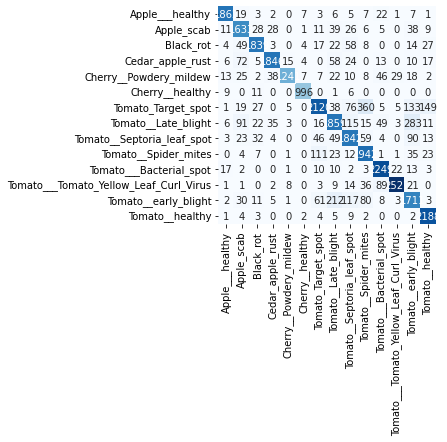

In [46]:
from sklearn.metrics import confusion_matrix

nb_classes = 14

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(val_loader):
        inputs = inputs
        classes = classes
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)

# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)

from sklearn.metrics import confusion_matrix
import seaborn as sns

matrix_confusion = confusion_matrix(predlist, lbllist)
sns.heatmap(matrix_confusion, square=True, annot=True, xticklabels=data.classes, yticklabels=data.classes, cmap='Blues', fmt='d', cbar=False)


In [48]:
#Testing classification accuracy for individual classes.
classes = ['Apple___healthy', 'Apple_scab', 'Black_rot', 'Cedar_apple_rust', 'Cherry__Powdery_mildew', 'Cherry__healthy', 'Tomato_Target_spot', 'Tomato__Late_blight', 'Tomato__Septoria_leaf_spot', 'Tomato__Spider_mites', 'Tomato___Bacterial_spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato__early_blight', 'Tomato__healthy']
class_correct = list(0. for i in range(14))
class_total = list(0. for i in range(14))
c = []
with torch.no_grad():
    for data in val_loader:
        images, labels = data[0], data[1]
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted==labels).squeeze()
        # print(c)
        for i in range(14):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
print(c.type())
for i in range(14):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))



torch.BoolTensor
Accuracy of Apple___healthy : 95 %
Accuracy of Apple_scab : 83 %
Accuracy of Black_rot : 91 %
Accuracy of Cedar_apple_rust : 93 %
Accuracy of Cherry__Powdery_mildew : 97 %
Accuracy of Cherry__healthy : 99 %
Accuracy of Tomato_Target_spot : 87 %
Accuracy of Tomato__Late_blight : 77 %
Accuracy of Tomato__Septoria_leaf_spot : 79 %
Accuracy of Tomato__Spider_mites : 77 %
Accuracy of Tomato___Bacterial_spot : 89 %
Accuracy of Tomato___Tomato_Yellow_Leaf_Curl_Virus : 98 %
Accuracy of Tomato__early_blight : 72 %
Accuracy of Tomato__healthy : 89 %


In [49]:
avg = 0
for i in range(14):
  temp = (100 * class_correct[i] / class_total[i])
  avg = avg + temp
avg = avg/14
print('Average accuracy = ', avg)

Average accuracy =  88.06137680618966


In [54]:
!sudo cp /content/lightning_logs/version_0/checkpoints/epoch=24-step=108150.ckpt /content/gdrive/MyDrive